In [ ]:
"""
 El objetivo siguiente es: 
- Predecir la probabilidad de que un usuario compre basado en comportamiento y transacciones.
- Evaluar efectividad de campañas de marketing mediante uplift modeling.

Cliente objetivo:
- Sellers premium
- Marcas interesadas en targeting
- Equipos internos de marketing

Outputs:
- Propensity score (0-1)
- Uplift score (0-1)
- Segmentación de usuarios
- Visualizaciones explicativas (SHAP, Gains, Qini)
"""

In [1]:
from pathlib import Path
import pandas as pd

DATA_RAW = Path("../data/raw")

users = pd.read_csv(DATA_RAW / "users.csv")
events = pd.read_csv(DATA_RAW / "events.csv")
transactions = pd.read_csv(DATA_RAW / "transaction_items.csv")
products = pd.read_csv(DATA_RAW / "products.csv")
marketing = pd.read_csv(DATA_RAW / "uplift_marketing.csv")

In [4]:
#Vriables
events["timestamp"] = pd.to_datetime(events["timestamp"], errors="coerce")
user_event_counts = events.groupby("user_id").size().rename("num_events")
avg_time_between_events = (
    events.sort_values(["user_id", "timestamp"])
    .groupby("user_id")["timestamp"]
    .diff()
    .dt.total_seconds()
    .groupby(events["user_id"])
    .mean()
    .rename("avg_time_between_events")
)

total_spend = (
    transactions
    .merge(products[["product_id", "price"]], on="product_id", how="left")
    .assign(total=lambda x: x["price"] * x["quantity"])
    .groupby("user_id")["total"]
    .sum()
    .rename("total_spend")
)

purchase_frequency = transactions.groupby("user_id").size().rename("purchase_frequency")

X = pd.DataFrame({
    "num_events": user_event_counts,
    "avg_time_between_events": avg_time_between_events,
    "total_spend": total_spend,
    "purchase_frequency": purchase_frequency
}).fillna(0)

X["is_buyer"] = X.index.isin(transactions["user_id"]).astype(int)

In [3]:
# Ver las columnas y algunas filas
print("Columnas disponibles en:")
print(events.columns.tolist())
display(events.head())

Columnas disponibles en:
['event_id', 'user_id', 'event_type', 'product_id', 'timestamp', 'revenue']


,event_id,user_id,event_type,product_id,timestamp,revenue
0,1,12606,product_view,1840,2024-12-16 16:24:00,0.0
1,2,30164,product_view,2589,2024-04-28 06:46:00,0.0
2,3,15219,product_view,954,2024-06-25 07:41:00,0.0
3,4,44930,product_view,2381,2024-01-30 02:19:00,0.0
4,5,25657,product_view,686,2024-03-23 21:21:00,0.0


In [ ]:
# !pip install shap

   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ---------------------------------------- 549.1/549.1 kB 7.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 2.8/2.8 MB 14.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   --- ------------------------------------ 3.4/38.1 MB 15.3 MB/s eta 0:00:03
   ------ --------------------------------- 6.6/38.1 MB 15.4 MB/s eta 0:00:03
   ---------- ----------------------------- 9.7/38.1 MB 15.4 MB/s eta 0:00:02
   ------------- -------------------------- 12.6/38.1 MB 15.4 MB/s eta 0:00:02
   ---------------- ----------------------- 15.7/38.1 MB 15.4 MB/s eta 0:00:02
   ------------------- -------------------- 18.9/38.1 MB 15.4 MB/s eta 0:00:02
   ----------------------- ---------------- 22.0/38.1 MB 15.4 MB/s eta 0:00:02
   -------------------------- ------------- 25.2/38.1 MB 15.4 MB/s eta 0:00:01
   -


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


ROC-AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       919
           1       1.00      1.00      1.00      9081

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

X_train shape: (39999, 4)
SHAP values shape: (39999, 4, 2)


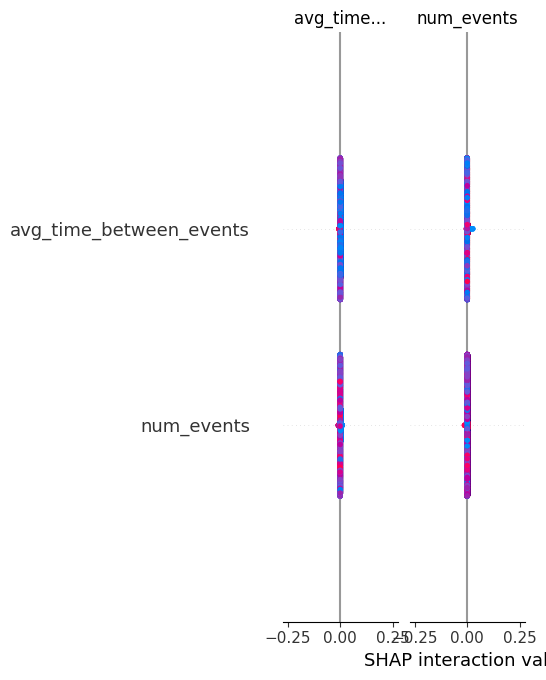

In [ ]:

# CELDA: Propensión a Compra + SHAP (Corregida)
import shap
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

# Separar target y features
y = X["is_buyer"]
X_features = X.drop(columns=["is_buyer"])

# Convertir categóricas en dummies
X_features_enc = pd.get_dummies(X_features, drop_first=True)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_features_enc, y, test_size=0.2, random_state=42, stratify=y
)

# Entrenar Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    class_weight="balanced"
)
rf_model.fit(X_train, y_train)

# Predicciones y métricas
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
y_pred = rf_model.predict(X_test)
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))

# Propensity Score
X_test = X_test.copy()
X_test["propensity_score"] = y_pred_proba

# SHAP 

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer(X_train)  # NOTA: llamamos al explainer como función

# Para binario, shap_values.values tiene shape (n_samples, n_features)
print("X_train shape:", X_train.shape)
print("SHAP values shape:", shap_values.values.shape)

# Plot importancia global
shap.summary_plot(shap_values.values, X_train, plot_type="bar")



In [11]:
# Uplift
uplift_df = X.merge(marketing, left_index=True, right_on="user_id", how="left").fillna(0)

features = ["num_events", "avg_time_between_events", "total_spend", "purchase_frequency"]
treatment_col = "grupo"  # 'control' o 'tratamiento'
target_col = "compra"

uplift_df["treatment"] = (uplift_df["grupo"] == "tratamiento").astype(int)

# Two-Model Approach
from sklearn.linear_model import LogisticRegression

model_t = LogisticRegression(max_iter=500)
model_t.fit(uplift_df[uplift_df["treatment"] == 1][features],
            uplift_df[uplift_df["treatment"] == 1][target_col])

model_c = LogisticRegression(max_iter=500)
model_c.fit(uplift_df[uplift_df["treatment"] == 0][features],
            uplift_df[uplift_df["treatment"] == 0][target_col])

uplift_df["y_t_pred"] = model_t.predict_proba(uplift_df[features])[:, 1]
uplift_df["y_c_pred"] = model_c.predict_proba(uplift_df[features])[:, 1]
uplift_df["uplift_score"] = uplift_df["y_t_pred"] - uplift_df["y_c_pred"]



In [18]:
# Segmentación 
import pandas as pd
import numpy as np

# DataFrame base con propensity_score
uplift_df = X_test.copy()
uplift_df["user_id"] = X_test.index

# Columnas de marketing necesarias
np.random.seed(42)
uplift_df["grupo"] = np.random.choice(["control", "tratamiento"], size=len(uplift_df))
uplift_df["descuento_ofrecido"] = np.random.randint(0, 20, size=len(uplift_df))

# Agregar columna de compra real (1 si compró, 0 si no)
purchase_per_user = events.groupby("user_id")["event_type"].apply(lambda x: int((x=="purchase").any()))
uplift_df["compra"] = uplift_df["user_id"].map(purchase_per_user).fillna(0).astype(int)

# Función de segmentación
def segment_uplift(row):
    if row["grupo"] == "tratamiento":
        if row["propensity_score"] >= 0.75:
            return "sure_thing"
        elif row["propensity_score"] >= 0.50:
            return "persuadable"
        else:
            return "sleeping_dog"
    else:
        return "sleeping_dog"

# Aplicar segmentación

uplift_df["segment"] = uplift_df.apply(segment_uplift, axis=1)

# Resultados
print(uplift_df["segment"].value_counts())
uplift_df[["user_id", "propensity_score", "grupo", "segment", "descuento_ofrecido", "compra"]].head(10)




segment
sleeping_dog    5450
sure_thing      4550
Name: count, dtype: int64


,user_id,propensity_score,grupo,segment,descuento_ofrecido,compra
user_id,,,,,,
11633,11633,1.0,control,sleeping_dog,18,0
26101,26101,1.0,tratamiento,sure_thing,7,0
19526,19526,1.0,control,sleeping_dog,6,0
6287,6287,1.0,control,sleeping_dog,15,1
41827,41827,1.0,control,sleeping_dog,18,1
39048,39048,1.0,tratamiento,sure_thing,5,1
11427,11427,1.0,control,sleeping_dog,19,0
36050,36050,1.0,control,sleeping_dog,10,0
26372,26372,1.0,control,sleeping_dog,4,1


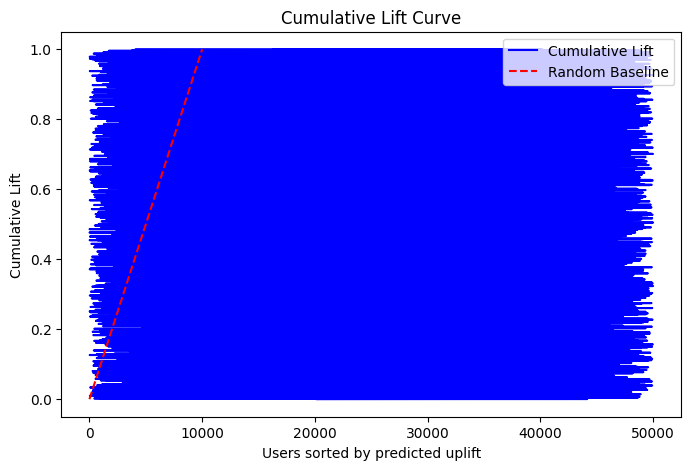

In [22]:
# Visualización 
# Qini / AUUC
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Crear uplift_score: diferencia básica entre tratamiento y control
uplift_df["uplift_score"] = np.where(
    uplift_df["grupo"] == "tratamiento",
    uplift_df["propensity_score"],
    0
)

# Ordenar por uplift_score descendente
uplift_df_sorted = uplift_df.sort_values("uplift_score", ascending=False)

# Curva acumulada de lift
uplift_df_sorted["cumulative_lift"] = uplift_df_sorted["compra"].cumsum() / uplift_df_sorted["compra"].sum()

# Curva de baseline aleatoria
baseline = np.arange(1, len(uplift_df_sorted)+1) / len(uplift_df_sorted)

# Gráfico
plt.figure(figsize=(8,5))
plt.plot(uplift_df_sorted["cumulative_lift"], label="Cumulative Lift", color="blue")
plt.plot(baseline, label="Random Baseline", color="red", linestyle="--")
plt.title("Cumulative Lift Curve")
plt.xlabel("Users sorted by predicted uplift")
plt.ylabel("Cumulative Lift")
plt.legend()
plt.show()



In [20]:
# Resultados finales
display(uplift_df[["user_id","propensity_score","uplift_score","segment"]].head(20))

,user_id,propensity_score,uplift_score,segment
user_id,,,,
11633,11633,1.0,0.0,sleeping_dog
26101,26101,1.0,1.0,sure_thing
19526,19526,1.0,0.0,sleeping_dog
6287,6287,1.0,0.0,sleeping_dog
41827,41827,1.0,0.0,sleeping_dog
39048,39048,1.0,1.0,sure_thing
11427,11427,1.0,0.0,sleeping_dog
36050,36050,1.0,0.0,sleeping_dog
26372,26372,1.0,0.0,sleeping_dog
